# Importing required libraries

In [1]:
import matplotlib
import pandas as pd
import numpy as np
import math
from numpy import argmax
import sys
from IPython.display import display
import warnings
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import callbacks

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
import numpy as np
import time
import statistics

# library options
%matplotlib inline
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

from keras import backend
 
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [2]:
# Monte Carlo Dropout Layer
class MonteCarloDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

# Read in the Train and Test data

In [3]:
X_train = np.array(pd.read_parquet('data/X_train.parquet').drop(['sum_day_1','sum_day_2','sum_day_3','gradient','clumpiness'], axis=1)).astype('float')
X_test = np.array(pd.read_parquet('data/X_test.parquet').drop(['sum_day_1','sum_day_2','sum_day_3','gradient','clumpiness'], axis=1)).astype('float')

y_test_class = np.array(pd.read_parquet('data/y_test.parquet')['sum_payments_package_key_ltv_class'])
y_train_class = np.array(pd.read_parquet('data/y_train.parquet')['sum_payments_package_key_ltv_class'])                        
#y_test_class = np.array(pd.read_parquet('data/y_test.parquet')['sum_payments_package_key_ltv_class'].apply(lambda x: 0 if x == 'low' else 1 if x == "medium" else 2 if x == "high" else -1)).astype('float')
#y_train_class = np.array(pd.read_parquet('data/y_test.parquet')['sum_payments_package_key_ltv_class'].apply(lambda x: 0 if x == 'low' else 1 if x == "medium" else 2 if x == "high" else -1)).astype('float')
y_test_reg = np.array(pd.read_parquet('data/y_test.parquet')['sum_payments_package_key_ltv']).astype('float')
y_train_reg = np.array(pd.read_parquet('data/y_train.parquet')['sum_payments_package_key_ltv']).astype('float')

# Check Data before Modelling 

In [4]:
print('Training Features Shape:', X_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Training Labels Regression Shape:', y_train_reg.shape)
print('Testing Labels Regression Shape:', y_test_reg.shape)

Training Features Shape: (111791, 175)
Testing Features Shape: (27948, 175)
Training Labels Regression Shape: (111791,)
Testing Labels Regression Shape: (27948,)


# Hyperparameter Tuning

In [5]:
def model_builder(hp):
    model = keras.Sequential()

    # layer 01
    layer_01 = hp.Choice('layer_01', values = ['False','True'])
    if layer_01:
        units_01 = hp.Int('units_01', min_value=64, max_value=1024, step=32)
        activation_01 = hp.Choice('activation_01', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_01 = hp.Choice('kernel_01', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_01, activation = activation_01, kernel_initializer=kernel_initializer_01, input_shape = (X_train.shape[1],)))
    
    batch_01 = hp.Choice('batch_01', values = ['False','True'])
    if batch_01:
        model.add(BatchNormalization())
    
    drop_01 = hp.Choice('drop_01', values = ['False','drop','Monte'])
    if drop_01 == 'drop':
        dropout_01 = hp.Float('dropout_01', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_01))
    elif drop_01 == 'Monte':
        monte_01 = hp.Float('monte_01', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_01))
    
    # layer 02
    layer_02 = hp.Choice('layer_02', values = ['False','True'])
    if layer_02:
        units_02 = hp.Int('units_02', min_value = 32, max_value = 512, step=32)
        activation_02 = hp.Choice('activation_02', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_02 = hp.Choice('kernel_02', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_02, activation = activation_02, kernel_initializer=kernel_initializer_02))
    
    batch_02 = hp.Choice('batch_02', values = ['False','True'])
    if batch_02:
        model.add(BatchNormalization())
        
    drop_02 = hp.Choice('drop_02', values = ['False','drop','Monte'])
    if drop_02:
        dropout_02 = hp.Float('dropout_02', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_02))
    elif drop_02 == 'Monte':
        monte_02 = hp.Float('monte_02', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_02))
    
    # layer 03
    layer_03 = hp.Choice('layer_03', values = ['False','True'])
    if layer_03:
        units_03 = hp.Int('units_03', min_value = 32, max_value = 512, step=32)
        activation_03 = hp.Choice('activation_03', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_03 = hp.Choice('kernel_03', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_03, activation = activation_03, kernel_initializer=kernel_initializer_03))
    
    drop_03 = hp.Choice('drop_03', values = ['False','drop','Monte'])
    if drop_03:
        dropout_03 = hp.Float('dropout_03', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_03))
    elif drop_03 == 'Monte':
        monte_03 = hp.Float('monte_03', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_03))
    
    batch_03 = hp.Choice('batch_03', values = ['False','True'])
    if batch_03:
        model.add(BatchNormalization())
    
    # layer 04
    layer_04 = hp.Choice('layer_04', values = ['False','True'])
    if layer_04:
        units_04 = hp.Int('units_04', min_value = 16, max_value = 512, step=32)
        activation_04 = hp.Choice('activation_04', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_04 = hp.Choice('kernel_04', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_04, activation = activation_04, kernel_initializer=kernel_initializer_04))
    
    drop_04 = hp.Choice('drop_04', values = ['False','drop','Monte'])
    if drop_04:
        dropout_04 = hp.Float('dropout_04', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_04))
    elif drop_04 == 'Monte':
        monte_04 = hp.Float('monte_04', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_04))
        
    batch_04 = hp.Choice('batch_04', values = ['False','True'])
    if batch_04:
        model.add(BatchNormalization())
    
    # layer 05
    layer_05 = hp.Choice('layer_05', values = ['False','True'])
    if layer_05:
        units_05 = hp.Int('units_05', min_value = 16, max_value = 256, step=32)
        activation_05 = hp.Choice('activation_05', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_05 = hp.Choice('kernel_05', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_05, activation = activation_05, kernel_initializer=kernel_initializer_05))
    
    drop_05 = hp.Choice('drop_05', values = ['False','drop','Monte'])
    if drop_05:
        dropout_05 = hp.Float('dropout_05', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_05))
    elif drop_05 == 'Monte':
        monte_05 = hp.Float('monte_05', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_05))
        
    batch_05 = hp.Choice('batch_05', values = ['False','True'])
    if batch_05:
        model.add(BatchNormalization())
    
    # layer 06
    layer_06 = hp.Choice('layer_06', values = ['False','True'])
    if layer_06:
        units_06 = hp.Int('units_06', min_value = 4, max_value = 16, step=4)
        activation_06 = hp.Choice('activation_06', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_06 = hp.Choice('kernel_06', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_06, activation = activation_06, kernel_initializer=kernel_initializer_06))
        
    # layer 07
    layer_07 = hp.Choice('layer_07', values = ['False','True'])
    if layer_07:
        units_07 = hp.Int('units_07', min_value = 4, max_value = 16, step=4)
        activation_07 = hp.Choice('activation_07', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_07 = hp.Choice('kernel_07', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_07, activation = activation_07, kernel_initializer=kernel_initializer_07))    
    
    # layer 08
    layer_08 = hp.Choice('layer_08', values = ['False','True'])
    if layer_08:
        units_08 = hp.Int('units_08', min_value = 4, max_value = 16, step=4)
        activation_08 = hp.Choice('activation_08', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_08 = hp.Choice('kernel_08', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_08, activation = activation_08, kernel_initializer=kernel_initializer_08))
        
    # layer 09
    layer_09 = hp.Choice('layer_06', values = ['False','True'])
    if layer_09:
        units_09 = hp.Int('units_06', min_value = 4, max_value = 16, step=4)
        activation_09 = hp.Choice('activation_09', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_09 = hp.Choice('kernel_09', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_09, activation = activation_09, kernel_initializer=kernel_initializer_09))
        
    # layer 10
    layer_10 = hp.Choice('layer_10', values = ['False','True'])
    if layer_10:
        units_10 = hp.Int('units_10', min_value = 4, max_value = 16, step=4)
        activation_10 = hp.Choice('activation_10', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_10 = hp.Choice('kernel_10', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_10, activation = activation_10, kernel_initializer=kernel_initializer_10))
    
    model.add(Dense(1))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss = 'mse', metrics = ['mse', 'mae',rmse,'mape','msle'])

    return model

In [6]:
# Select Tuner Hyperband
tuner = kt.Hyperband(model_builder,
                     objective = 'mse',
                     max_epochs = 40,
                     factor = 6,
                     project_name = 'MLP_Regression_withoutTA_01')

stop_early = callbacks.EarlyStopping(monitor='loss', patience=7)

INFO:tensorflow:Reloading Oracle from existing project ./MLP_Regression_withoutTA_01/oracle.json
INFO:tensorflow:Reloading Tuner from ./MLP_Regression_withoutTA_01/tuner0.json


In [ ]:
tuner.search(X_train, y_train_reg, epochs=100, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print('The hyperparameter search is complete. The optimal model is:')
print(best_hps)

Trial 93 Complete [00h 16m 59s]
mse: 747.3514404296875

Best mse So Far: 423.8593444824219
Total elapsed time: 01h 28m 35s

Search: Running Trial #94

Hyperparameter    |Value             |Best Value So Far 
layer_01          |False             |False             
units_01          |704               |896               
activation_01     |sigmoid           |relu              
kernel_01         |glorot_uniform    |he_normal         
batch_01          |True              |True              
drop_01           |drop              |False             
layer_02          |True              |True              
units_02          |288               |416               
activation_02     |LeakyReLU         |tanh              
kernel_02         |glorot_normal     |glorot_normal     
batch_02          |False             |False             
drop_02           |False             |drop              
dropout_02        |0.4               |0.2               
layer_03          |False             |False        

In [ ]:
tuner.results_summary()

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train_reg,validation_split=0.33, epochs = 100)

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mse'], color = '#4472C4')
plt.plot(history.history['val_mse'], color = '#ED7D31')
plt.title('Model MSE')
plt.ylabel('MSE')
#plt.ylim(0.7,0.98)
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('results/DNN_MSE_Reg_withoutTA.png')
plt.show()

In [11]:
val_loss_per_epoch = history.history['val_mse']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 6


In [12]:
start_time = time.time()
hypermodel = tuner.hypermodel.build(best_hps)
print(str(model),"--- %s seconds ---" % ((time.time() - start_time)))

# Retrain the model
history = hypermodel.fit(X_train, y_train_reg,validation_split=0.33, epochs=best_epoch)

<keras.engine.sequential.Sequential object at 0x7f897f3ad6d0> --- 0.2726469039916992 seconds ---
Epoch 1/6
2341/2341 [==============================] - 34s 14ms/step - loss: 1062.6206 - mse: 1062.6206 - mae: 17.3447 - rmse: 17.3447 - mape: 161.1957 - msle: 1.3404 - val_loss: 828.3538 - val_mse: 828.3538 - val_mae: 15.2710 - val_rmse: 15.2710 - val_mape: 191.4136 - val_msle: 0.8826
Epoch 2/6
2341/2341 [==============================] - 31s 13ms/step - loss: 853.6414 - mse: 853.6414 - mae: 16.4908 - rmse: 16.4908 - mape: 205.3966 - msle: 0.9748 - val_loss: 830.9115 - val_mse: 830.9115 - val_mae: 15.4284 - val_rmse: 15.4284 - val_mape: 205.0385 - val_msle: 0.9257
Epoch 3/6
2341/2341 [==============================] - 32s 14ms/step - loss: 827.3684 - mse: 827.3684 - mae: 16.2778 - rmse: 16.2778 - mape: 205.1104 - msle: 0.9504 - val_loss: 858.1063 - val_mse: 858.1063 - val_mae: 15.6815 - val_rmse: 15.6815 - val_mape: 197.6449 - val_msle: 0.8945
Epoch 4/6
2341/2341 [=========================

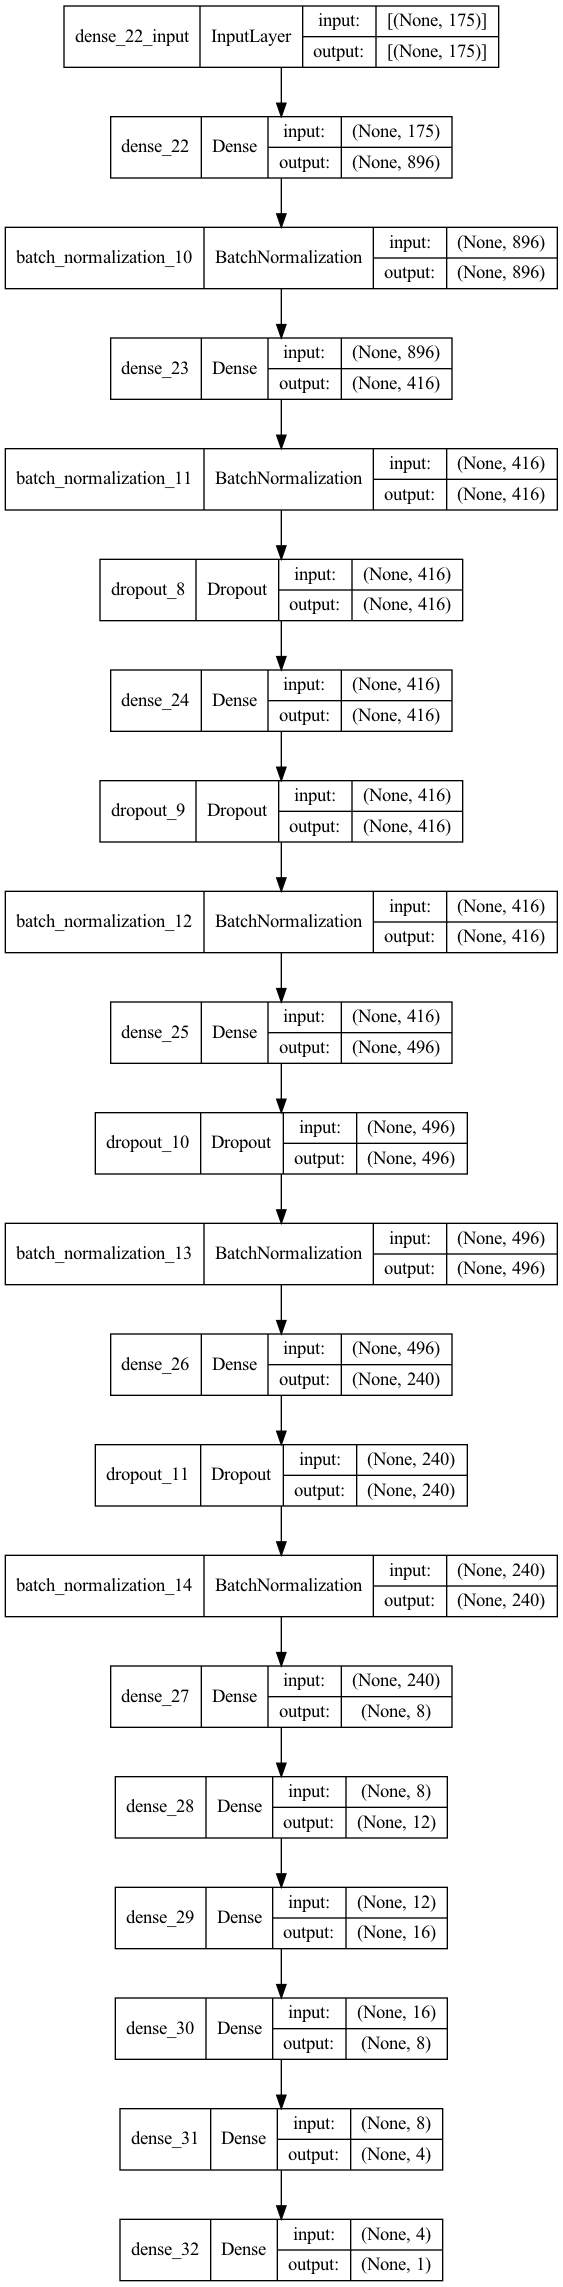

In [13]:
# Print Model Layout:
plot_model(hypermodel, to_file='results/hypermodel_reg_withoutTA.png', show_shapes=True)

In [14]:
eval_result = hypermodel.evaluate(X_test, y_test_reg)
print("[loss, MSE, MAE, RMSE, MAPE, MSLE]:", eval_result)

874/874 [==============================] - 3s 4ms/step - loss: 857.5197 - mse: 857.5197 - mae: 16.5334 - rmse: 16.5334 - mape: 219.2218 - msle: 0.9812
[loss, MSE, MAE, RMSE, MAPE, MSLE]: [857.5196533203125, 857.5196533203125, 16.533411026000977, 16.533411026000977, 219.2218017578125, 0.9812061786651611]


# 10-Fold Cross-Validation

In [15]:
# Define the K-fold Cross Validator
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
loss_per_fold = []
MAE_per_fold = []

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train_reg, y_test_reg), axis=0)

for train, test in kfold.split(inputs, targets):

    best_model = tuner.hypermodel.build(best_hps)

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    best_model.fit(inputs[train], targets[train], epochs=best_epoch, verbose=0, callbacks = [stop_early])
    score = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {score}')

    yhat = model.predict(inputs[test])
    print('MAE: %.3f' % mean_absolute_error(targets[test], yhat))

    MAE_per_fold.append(mean_absolute_error(targets[test], yhat))
    loss_per_fold.append(score)

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: [503.68316650390625, 503.68316650390625, 10.148368835449219, 10.148371696472168, 115.04476928710938, 0.5470153093338013]
MAE: 10.148
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: [491.9491271972656, 491.9491271972656, 10.133918762207031, 10.133919715881348, 114.1951675415039, 0.5376395583152771]
MAE: 10.134
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: [494.4006042480469, 494.4006042480469, 10.184282302856445, 10.184282302856445, 117.02855682373047, 0.5601755380630493]
MAE: 10.184
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: [520.5831909179688, 520.5831909179688, 10.320713996887207, 10.320713996887207, 117.72953033447266, 0.5513625144958496]
MAE: 10.321
---------------

In [16]:
loss = []
mse = []
mae = []
rmse = []
mape = []
msle = []
for i in range(len(loss_per_fold)):
    loss.append(loss_per_fold[i][0])
    mse.append(loss_per_fold[i][1])
    mae.append(loss_per_fold[i][2])
    rmse.append(loss_per_fold[i][3])
    mape.append(loss_per_fold[i][4])
    msle.append(loss_per_fold[i][5])

In [17]:
print("Mean Loss: %s" % statistics.mean(loss))
print("Mean MSE: %s" % statistics.mean(mse))
print("Mean MAE: %s" % statistics.mean(mae))
print("Mean RMSE: %s" % statistics.mean(rmse))
print("Mean MAPE: %s" % statistics.mean(mape))
print("Mean MSLE: %s" % statistics.mean(msle))

Mean Loss: 497.0334045410156
Mean MSE: 497.0334045410156
Mean MAE: 10.165661811828613
Mean RMSE: 10.165662288665771
Mean MAPE: 116.62901916503907
Mean MSLE: 0.5503499865531921


In [18]:
print("SD Loss: %s" % statistics.stdev(loss))
print("SD MSE: %s" % statistics.stdev(mse))
print("SD MAE: %s" % statistics.stdev(mae))
print("SD RMSE: %s" % statistics.stdev(rmse))
print("SD MAPE: %s" % statistics.stdev(mape))
print("SD MSLE: %s" % statistics.stdev(msle))

SD Loss: 17.17607537672936
SD MSE: 17.17607537672936
SD MAE: 0.15006363644831072
SD RMSE: 0.15006354646012754
SD MAPE: 1.368879833057419
SD MSLE: 0.008698756374014089


# Plot Results

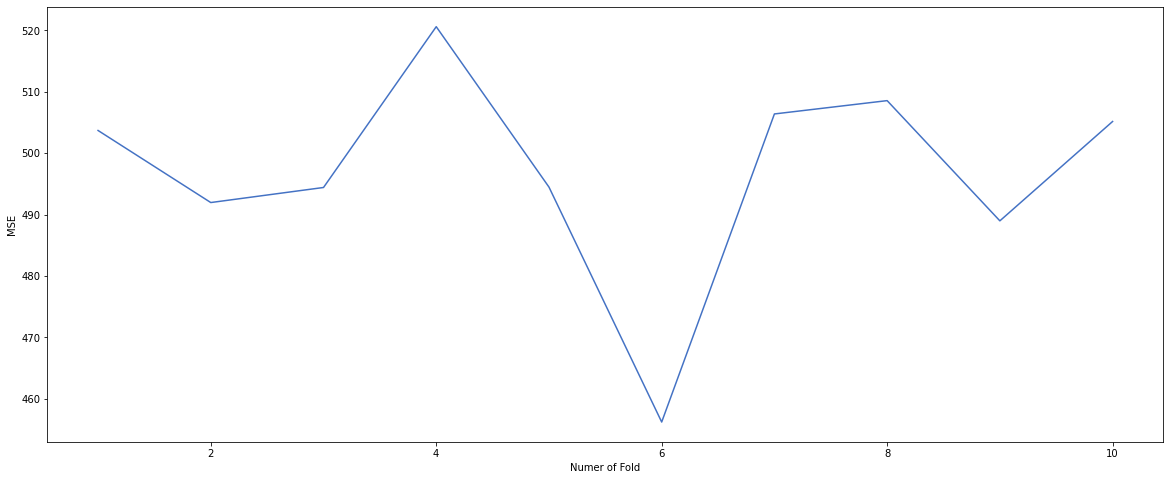

In [19]:
plt.figure(figsize=(20, 8))
#Create the plots
plt.plot(range(1,len(loss)+1),loss, color = '#4472C4', label = 'MSE')
#plt.plot(range(1,len(mape)+1),mape, color='red', label = 'MAPE')
#Create the title, axis description and legend
#plt.title('Results KFOLD Cross-Validation')
plt.ylabel('MSE')
plt.xlabel("Numer of Fold")
#plt.legend()
#plt.grid()
plt.xticks(rotation = 0)
plt.savefig('results/DNN_KFold_MSE_withoutTA.png')
plt.rcParams.update({'font.size': 12})

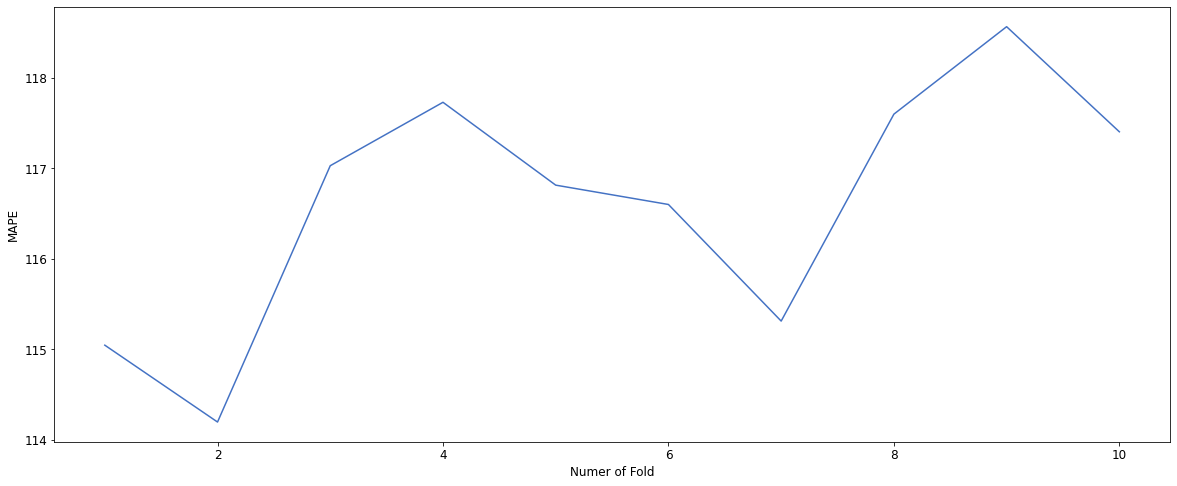

In [20]:
plt.figure(figsize=(20, 8))
#Create the plots
#plt.plot(range(1,len(loss)+1),loss, color='blue', label = 'MSE')
plt.plot(range(1,len(mape)+1),mape, color = '#4472C4', label = 'MAPE')
#Create the title, axis description and legend
#plt.title('Results KFOLD Cross-Validation')
plt.ylabel('MAPE')
plt.xlabel("Numer of Fold")
#plt.legend()
#plt.grid()
plt.xticks(rotation = 0)
plt.savefig('results/DNN_KFold_MAPE_withoutTA.png')
plt.rcParams.update({'font.size': 12})

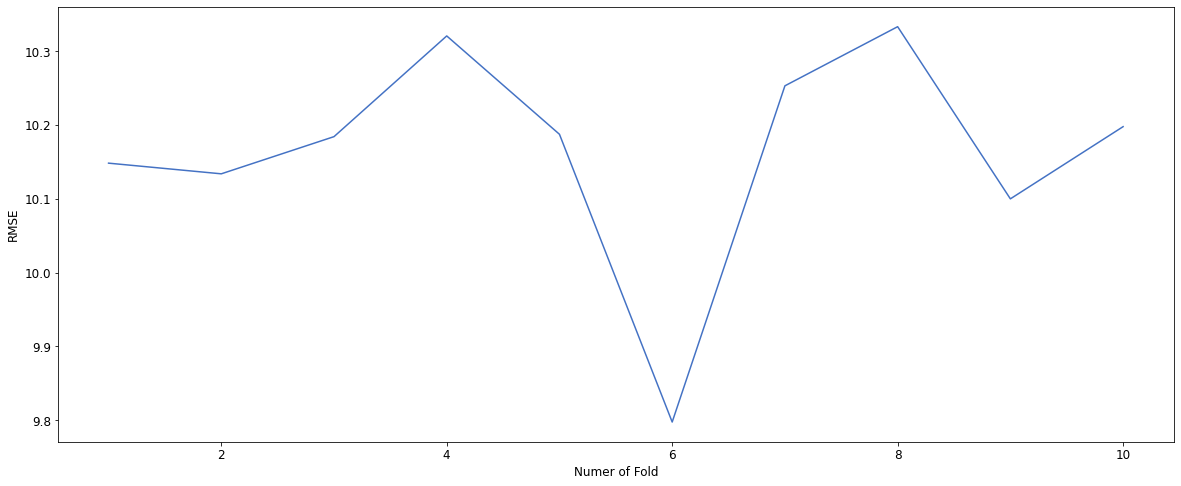

In [21]:
plt.figure(figsize=(20, 8))
#Create the plots
#plt.plot(range(1,len(MAE_per_fold)+1),MAE_per_fold, color='blue', label = 'MAE')
plt.plot(range(1,len(rmse)+1),rmse, color = '#4472C4', label = 'RMSE')
#Create the title, axis description and legend
#plt.title('Results KFOLD Cross-Validation')
plt.ylabel('RMSE')
plt.xlabel("Numer of Fold")
#plt.legend()
#plt.grid()
plt.xticks(rotation = 0)
plt.savefig('results/DNN_KFold_RMSE_withoutTA.png')
plt.rcParams.update({'font.size': 12})